In [132]:
import numpy as np
from data import text_data
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

In [133]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/satya-
[nltk_data]     tt0492/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/satya-
[nltk_data]     tt0492/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [134]:
raw_text = text_data
raw_text = [x.split() for x in raw_text]

In [135]:
stop_words = set(stopwords.words('english'))

# Function to remove stopwords and tokenize sentences
def preprocess_sentences(sentences):
    processed_sentences = []
    for sentence in sentences:
        # Tokenize the sentence into words
        tokens = word_tokenize(sentence.lower())  # Convert to lowercase to maintain consistency
        # Remove stopwords and non-alphabetic words
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        processed_sentences.append(filtered_tokens)
    return processed_sentences

# Process the sentences
processed_data = preprocess_sentences(text_data)

In [136]:
raw_text = processed_data

In [137]:
vocabulary = []
for sentence in raw_text:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [138]:
len(word2idx)

368

In [139]:
vocabulary_size

368

In [159]:
window_size = 5
context_size = 2
data = []
for sentence in raw_text:
    for i in range(window_size//2,len(sentence)):
        d = []
        for j in range(context_size):
            d.append(sentence[i-j-1])
            if i + j + 1 < len(sentence):
                d.append(sentence[i+j+1])
        if(len(d) == 2 * context_size):
            data.append((d,sentence[i]))
data[:10]

[(['brown', 'jumped', 'quick', 'lazy'], 'fox'),
 (['fox', 'lazy', 'brown', 'dog'], 'jumped'),
 (['sea', 'sea', 'sells', 'shore'], 'shells'),
 (['shells', 'shore', 'sea', 'every'], 'sea'),
 (['sea', 'every', 'shells', 'morning'], 'shore'),
 (['hand', 'two', 'bird', 'bush'], 'worth'),
 (['loved', 'never', 'better', 'loved'], 'lost'),
 (['speak', 'words', 'actions', 'words'], 'louder'),
 (['louder', 'words', 'speak', 'still'], 'words'),
 (['words', 'still', 'louder', 'matter'], 'words')]

In [160]:
len(data)

190

In [161]:
class CBOW(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super(CBOW,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_size)
        self.linear1 = nn.Linear(embedding_size,128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(128, vocab_size)
        self.final = nn.LogSoftmax(dim=1)
    
    def forward(self,context_words):
        embeds = sum(self.embedding(context_words)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation1(out)
        out = self.linear2(out)
        out = self.final(out)
        return out

In [162]:
model = CBOW(embedding_size=50,vocab_size=vocabulary_size)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01,momentum=0.1)
losses = []

In [163]:
for epochs in range(300):
    total_loss = 0
    for context,target in data:
        context_vector = torch.tensor([word2idx[word] for word in context],dtype=torch.long)
        target = torch.tensor([word2idx[target]],dtype=torch.long)

        optimizer.zero_grad()

        output = model(context_vector)
        loss = criterion(output,target)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()
    if(epochs % 100 == 0):
        print(f"Epoch : {epochs} - Loss : {total_loss}")
    losses.append(total_loss)

Epoch : 0 - Loss : 1136.7767958641052
Epoch : 100 - Loss : 0.701700221397914
Epoch : 200 - Loss : 0.3234378009510692


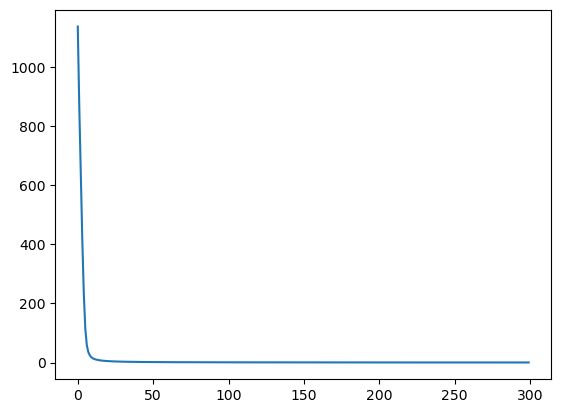

In [164]:
plt.plot(losses)

In [165]:
vocabulary_size

368

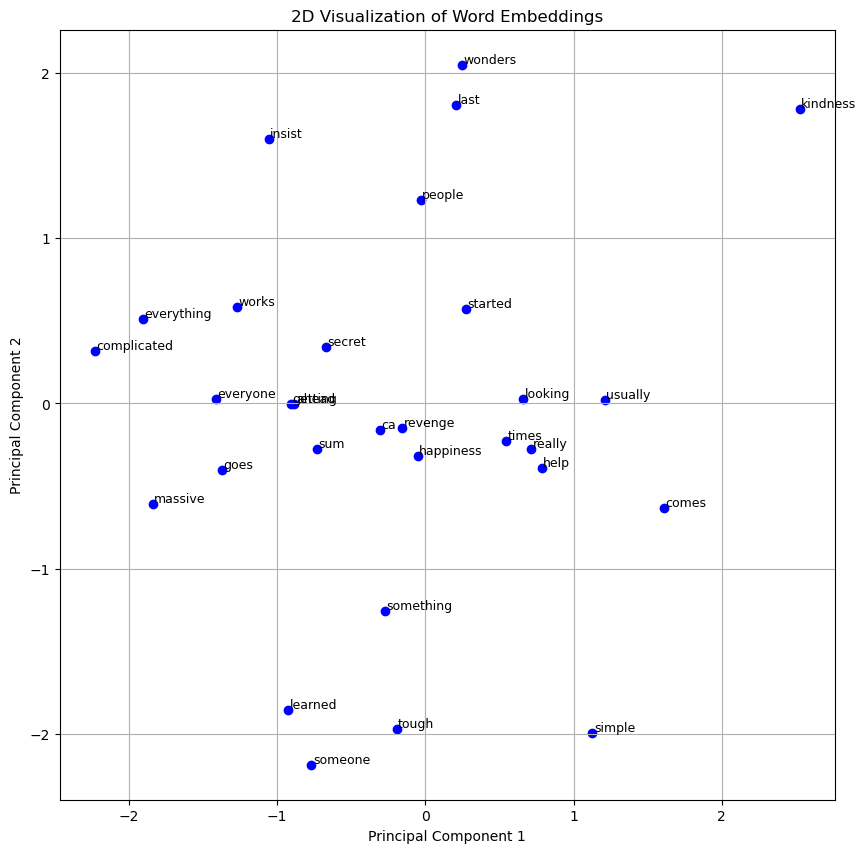

In [173]:
from sklearn.decomposition import PCA

embeddings = model.embedding.weight.data  # Shape: (vocab_size, embedding_dim)

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)  # Shape: (vocab_size, 2)

words = list(word2idx.keys())

plt.figure(figsize=(10, 10))
for i, word in enumerate(words[150:180]):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, marker='o', color='blue')
    plt.text(x + 0.01, y + 0.01, word, fontsize=9)  # Offset text slightly for visibility

plt.title("2D Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
